# Params

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [63]:
# device = 'cpu'
map_vpc = {'1': 0, '3': 1, '4': 2, '5': 3, '0': 4, '6': 5} # map labels: 1 = benign (0), we don't have 2, i = Gleason i (i-2) for i=[3:5]
num_classes = 6
batch_size = 32
magnifications = [10, 20, 40]
magnification=40
stains = ['HnE']
fold = 'fold1'

if fold == 'fold1':
    train_slides_vpc = [2, 5, 6, 7]
    val_slides_vpc = [3]
    test_slides_vpc = [1]
elif fold == 'fold2':
    train_slides_vpc = [1, 3, 6, 7]
    val_slides_vpc = [2]
    test_slides_vpc = [5]
elif fold == 'fold3':
    train_slides_vpc = [1, 2, 3, 5]
    val_slides_vpc = [7]
    test_slides_vpc = [6]
# else:
#     assert False 'Please choose the correct fold! - {"fold1", "fold2", "fold3"}'

# NEW: path to labels CSV + soft/hard label switch
labels_csv = "../data/VPC/patch_labels_majority.csv"  # <-- set to your CSV path
use_soft_labels = False  # True to use p0..p5; False to use hard_label

# model path unchanged
model_results_path = '../models/model_VPC/' + str(magnification) + '/' + fold + '/256_aug_model'

os.makedirs(os.path.dirname(model_results_path), exist_ok=True)


# Deprecated with CSV (images read via absolute paths in the CSV)
# path_VPC = "/home/user01/MS-RGCN/data/VPC/multiscale_patches_Train/"


# Import

In [64]:
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_auc_score
import numpy as np
import staintools
import random
import torchvision.transforms.functional as TF
import cv2 as cv

from glob import glob

# Utils

In [65]:
# a function to move tensors from the CPU to the GPU
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

def plotImage(img, ax=plt):
    img_pil = torchvision.transforms.ToPILImage()(img)
    img_size = torch.FloatTensor(img_pil.size)
    ax.imshow(img_pil)
    
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 90, 180, 270])
    
AUGMENTED_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    rotation_transform,
#     transforms.GaussianBlur(20, sigma=(0,0.1)),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)]
)

# Dataset

In [66]:
class VPCDataset(Dataset):
    def __init__(self, csv_file, slide_ids=None, magnification=None, augmentation=False, 
                 transform=transforms.ToTensor(), soft_labels=False):
        """
        Args:
            csv_file (str): Path to CSV with patch paths and labels.
            slide_ids (list[int], optional): List of slide IDs to include.
            magnification (int, optional): Magnification to filter on (10, 20, 40).
            augmentation (bool): Whether to apply AUGMENTED_TRANSFORM.
            transform (callable): Transform to apply to each image.
            soft_labels (bool): If True, returns p0..p5 probabilities.
        """
        import pandas as pd
        self.data = pd.read_csv(csv_file)
        
        # Filter by slide IDs if provided
        if slide_ids is not None:
            self.data = self.data[self.data["path"].str.contains(
                "|".join([f"slide00{i}_" for i in slide_ids])
            )]
        
        # Filter by magnification if provided
        if magnification is not None:
            self.data = self.data[self.data["path"].str.contains(f"/{magnification}/")]
        
        self.transform = transform
        self.augmentation = augmentation
        self.soft_labels = soft_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = io.imread(row["path"])
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_CUBIC)
        
        if self.soft_labels:
            label = row[["p0", "p1", "p2", "p3", "p4", "p5"]].values.astype("float32")
        else:
            label = int(row["hard_label"])
        
        if self.transform:
            img = self.transform(img)
        
        return {'img': img, 'label': label}


In [67]:
dataset_train = VPCDataset(labels_csv, slide_ids=train_slides_vpc, magnification=magnification, 
                           augmentation=False, transform=AUGMENTED_TRANSFORM, soft_labels=use_soft_labels)
dataset_val = VPCDataset(labels_csv, slide_ids=val_slides_vpc, magnification=magnification, 
                         augmentation=False, transform=transforms.ToTensor(), soft_labels=use_soft_labels)


In [68]:
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=False)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=2, shuffle=False, pin_memory=False)

In [69]:
iterator = iter(train_loader)
batch = next(iterator)

imgs = batch['img']          # shape: [B, 3, 256, 256]
labels = batch['label']      # hard: [B], soft: [B, 6] if use_soft_labels=True

In [70]:

print("imgs:", imgs.shape, imgs.dtype, "min:", imgs.min().item(), "max:", imgs.max().item())
print("labels shape:", getattr(labels, "shape", None), "dtype:", getattr(labels, "dtype", type(labels)))


imgs: torch.Size([32, 3, 256, 256]) torch.float32 min: 0.0 max: 1.0
labels shape: torch.Size([32]) dtype: torch.int64


(-0.5, 255.5, 255.5, -0.5)

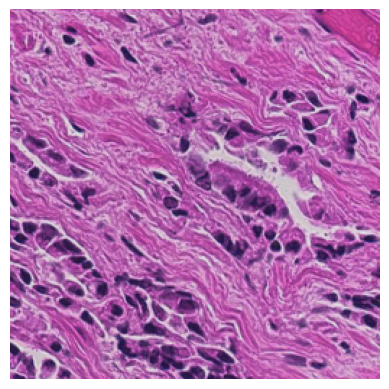

In [71]:
# Show one image
idx = 1 if imgs.shape[0] > 1 else 0
plt.imshow(imgs[idx].cpu().permute(1, 2, 0))
plt.axis("off")

In [72]:
print("Train samples:", len(dataset_train))


Train samples: 15905


In [73]:
print("Val samples:", len(dataset_val))


Val samples: 3493


In [74]:
# Show a couple of rows from the filtered CSV inside the dataset
dataset_train.data.head(3)
# Example paths and labels
for i in range(3):
    r = dataset_train.data.iloc[i]
    print(r["path"], "-> hard_label:", r["hard_label"])


/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/0_0.png -> hard_label: 4
/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/512_0.png -> hard_label: 4
/home/user01/MS-RGCN-Plus/data/VPC/multiscale_patches_Train/slide002_core002/512/40/1024_0.png -> hard_label: 4


# Model

In [84]:
class NN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Use the newer torchvision weights API (instead of pretrained=True)
        from torchvision.models import resnet18, ResNet18_Weights
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Final classification layer -> logits for num_classes
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=num_classes, bias=True)
        )

        print(self.model)

    def forward(self, dictionary):
        # returns logits [B, num_classes]
        return {'label': self.model(dictionary['img'])}

    def prediction(self, dictionary):
        # argmax over logits works for both hard/soft-label training
        return {'label': torch.argmax(self.forward(dictionary)['label'], dim=1)}

model = NN(num_classes=num_classes).cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training

## Training loop

[Epoch 30 | Iter 0/497] loss=1.4110 | last_val_acc=n/a |
[Epoch 30 | Iter 50/497] loss=1.2799 | last_val_acc=n/a |
[Epoch 30 | Iter 100/497] loss=1.3186 | last_val_acc=n/a |
[Epoch 30 | Iter 150/497] loss=1.4306 | last_val_acc=n/a |
[Epoch 30 | Iter 200/497] loss=1.1008 | last_val_acc=n/a |
[Epoch 30 | Iter 250/497] loss=1.5318 | last_val_acc=n/a |
[Epoch 30 | Iter 300/497] loss=1.7935 | last_val_acc=n/a |
[Epoch 30 | Iter 350/497] loss=1.2244 | last_val_acc=n/a |
[Epoch 30 | Iter 400/497] loss=1.2551 | last_val_acc=n/a |
[Epoch 30 | Iter 450/497] loss=1.0789 | last_val_acc=n/a |
[Epoch 30 | Iter 497/497] loss=2.8091 | last_val_acc=n/a |


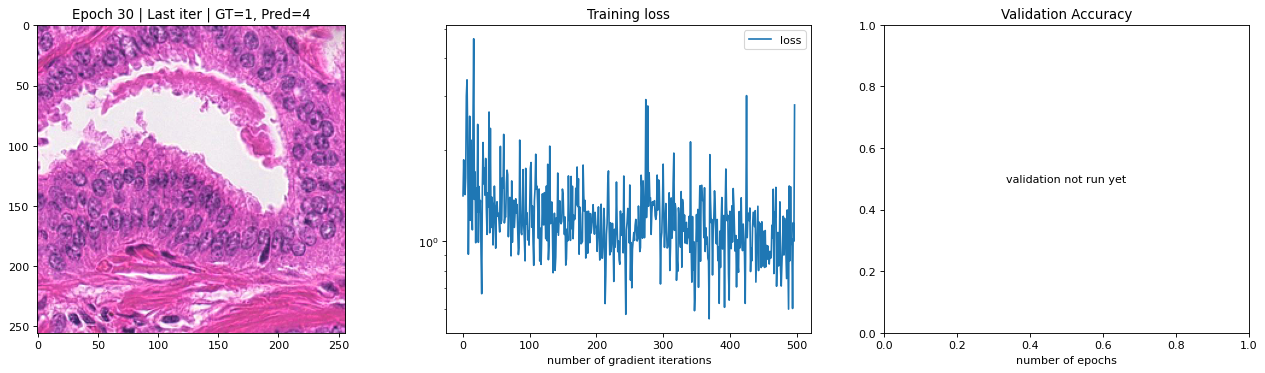

Epoch 30 done | last_loss=2.8091 | val_acc=0.6161 | saved=../models/model_VPC/40/fold1/256_aug_model_030_0.6161.pt
[Epoch 31 | Iter 0/497] loss=2.9205 | last_val_acc=0.6161 |
[Epoch 31 | Iter 50/497] loss=0.8594 | last_val_acc=0.6161 |
[Epoch 31 | Iter 100/497] loss=1.1609 | last_val_acc=0.6161 |
[Epoch 31 | Iter 150/497] loss=1.3200 | last_val_acc=0.6161 |
[Epoch 31 | Iter 200/497] loss=1.0457 | last_val_acc=0.6161 |
[Epoch 31 | Iter 250/497] loss=0.6942 | last_val_acc=0.6161 |
[Epoch 31 | Iter 300/497] loss=1.0215 | last_val_acc=0.6161 |
[Epoch 31 | Iter 350/497] loss=1.0122 | last_val_acc=0.6161 |
[Epoch 31 | Iter 400/497] loss=2.5562 | last_val_acc=0.6161 |
[Epoch 31 | Iter 450/497] loss=1.5833 | last_val_acc=0.6161 |
[Epoch 31 | Iter 497/497] loss=4.3226 | last_val_acc=0.6161 |


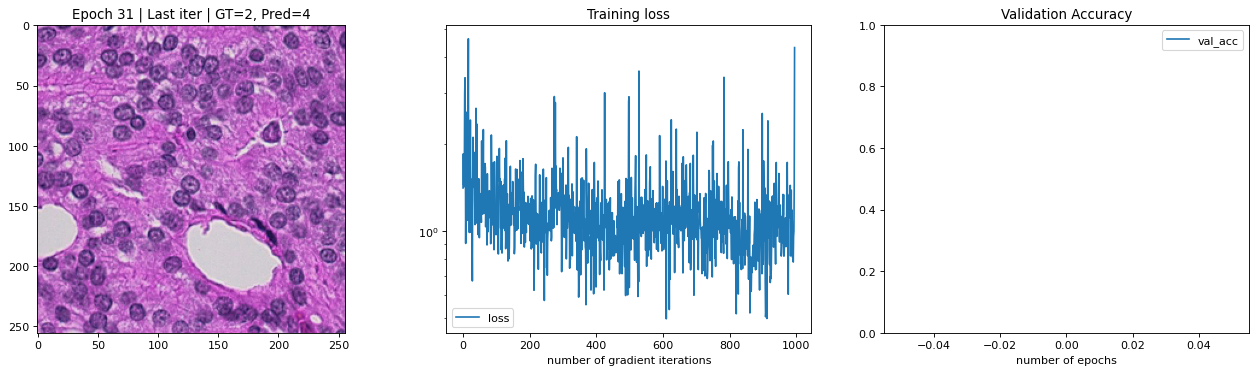

Epoch 31 done | last_loss=4.3226 | val_acc=0.6118 | saved=../models/model_VPC/40/fold1/256_aug_model_031_0.6118.pt
[Epoch 32 | Iter 0/497] loss=0.8846 | last_val_acc=0.6118 |
[Epoch 32 | Iter 50/497] loss=0.7798 | last_val_acc=0.6118 |
[Epoch 32 | Iter 100/497] loss=1.4602 | last_val_acc=0.6118 |
[Epoch 32 | Iter 150/497] loss=1.2142 | last_val_acc=0.6118 |
[Epoch 32 | Iter 200/497] loss=1.1189 | last_val_acc=0.6118 |
[Epoch 32 | Iter 250/497] loss=1.0653 | last_val_acc=0.6118 |
[Epoch 32 | Iter 300/497] loss=1.0323 | last_val_acc=0.6118 |
[Epoch 32 | Iter 350/497] loss=0.4258 | last_val_acc=0.6118 |
[Epoch 32 | Iter 400/497] loss=0.6548 | last_val_acc=0.6118 |
[Epoch 32 | Iter 450/497] loss=1.2694 | last_val_acc=0.6118 |
[Epoch 32 | Iter 497/497] loss=0.7225 | last_val_acc=0.6118 |


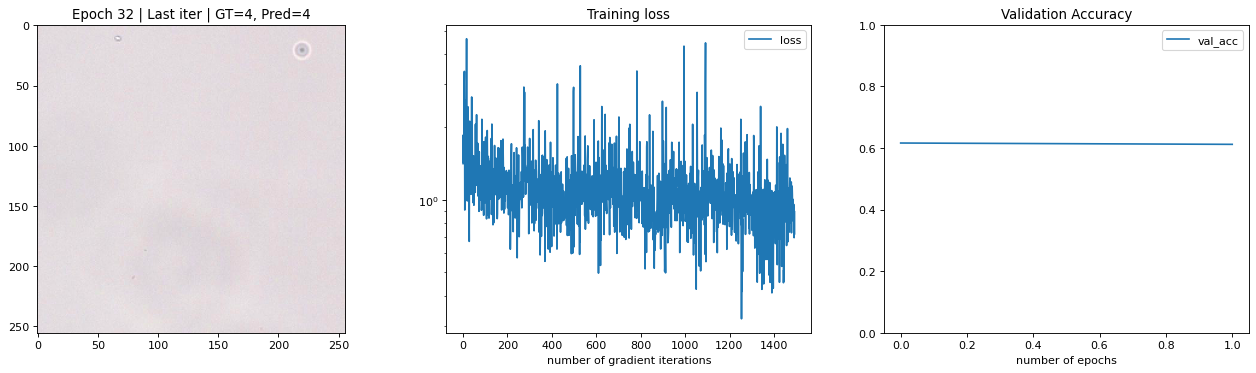

Epoch 32 done | last_loss=0.7225 | val_acc=0.6224 | saved=../models/model_VPC/40/fold1/256_aug_model_032_0.6224.pt
[Epoch 33 | Iter 0/497] loss=0.8136 | last_val_acc=0.6224 |
[Epoch 33 | Iter 50/497] loss=0.8797 | last_val_acc=0.6224 |
[Epoch 33 | Iter 100/497] loss=1.1260 | last_val_acc=0.6224 |


In [ ]:
# --- one-time: make sure the checkpoint dir exists ---
import os
os.makedirs(os.path.dirname(model_results_path), exist_ok=True)

# prepare plotting (single figure reused each epoch)
fig = plt.figure(figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
axes = fig.subplots(1, 3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 25], gamma=0.1)

device = "cuda"

# ---------- class weights from training CSV ----------
import numpy as np
import torch.nn.functional as F

if "hard_label" in dataset_train.data.columns:
    counts = np.bincount(dataset_train.data["hard_label"].astype(int).values, minlength=num_classes)
    class_weights = 1.0 / (counts + 1)
    class_weights = class_weights / class_weights.sum()
    weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
else:
    weights = torch.ones(num_classes, device=device) / num_classes  # fallback

# ---------- losses ----------
criterion_hard = nn.CrossEntropyLoss(weight=weights)

def soft_ce_loss(logits, target_probs):
    log_probs = F.log_softmax(logits, dim=1)
    loss_per_sample = -(target_probs * log_probs).sum(dim=1)
    return loss_per_sample.mean()

num_epochs = 10 #TODO 41

losses = []
val_accs = []

log_every = 50  # print every N iters

for epoch in range(30, 41): #TODO range(num_epochs)
    # --------- TRAIN ---------
    model.train()
    for i, batch_cpu in enumerate(train_loader):
        batch_gpu = dict_to_device(batch_cpu, device)
        pred = model(batch_gpu)  # {'label': logits [B, C]}

        # choose loss based on label type (hard vs soft)
        if isinstance(batch_gpu['label'], torch.Tensor) and batch_gpu['label'].ndim == 2:
            loss = soft_ce_loss(pred['label'], batch_gpu['label'])
        else:
            loss = criterion_hard(pred['label'], batch_gpu['label'].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # --------- PRINT LOGS (no plotting here) ---------
        if (i % log_every == 0) or (i == len(train_loader) - 1):
            # define last_val_str safely even before first validation
            last_val_str = f"{val_accs[-1]:.4f}" if len(val_accs) > 0 else "n/a"

            # optional: show current GT/PRED ids in the log line
            # if isinstance(batch_cpu['label'], torch.Tensor) and batch_cpu['label'].ndim == 2:
            #     gt_id = int(torch.argmax(batch_cpu['label'][0]).item())
            # else:
            #     gt_id = int(batch_cpu['label'][0])
            # pred_id = int(torch.argmax(pred['label'][0]).item())

            # print(f"[Epoch {epoch} | Iter {i}/{len(train_loader)-1}] "
            #       f"loss={losses[-1]:.4f} | last_val_acc={last_val_str} | GT={gt_id} Pred={pred_id}")
            
            
            print(f"[Epoch {epoch} | Iter {i}/{len(train_loader)-1}] "
                  f"loss={losses[-1]:.4f} | last_val_acc={last_val_str} |")

        # ---- plot ONLY at the end of the epoch (when i hits last iter) ----
        if i == len(train_loader) - 1:
            # clear axes so each epoch snapshot is clean
            axes[0].cla(); axes[1].cla(); axes[2].cla()

            # left: show an input image + title
            from matplotlib import pyplot as plt
            plotImage(batch_cpu['img'][0], ax=axes[0])
            if isinstance(batch_cpu['label'], torch.Tensor) and batch_cpu['label'].ndim == 2:
                gt_label = int(torch.argmax(batch_cpu['label'][0]).item())
            else:
                gt_label = int(batch_cpu['label'][0])
            pred_top1 = int(torch.argmax(pred['label'][0]).item())
            axes[0].set_title(f'Epoch {epoch} | Last iter | GT={gt_label}, Pred={pred_top1}')

            # middle: training loss curve
            axes[1].plot(losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # right: validation accuracy curve (may be empty on epoch 0 pre-val)
            if len(val_accs) > 0:
                axes[2].plot(val_accs, label='val_acc')
                axes[2].set_ylim(0, 1)
                axes[2].legend()
            else:
                axes[2].text(0.5, 0.5, "validation not run yet", ha='center', va='center')
                axes[2].set_ylim(0, 1)
            axes[2].set_title('Validation Accuracy')
            axes[2].set_xlabel('number of epochs')

            display.display(plt.gcf())  # append a snapshot for this epoch

    # --------- VALIDATION ---------
    model.eval()
    n_val = len(dataset_val)
    pred_val = np.zeros(n_val, dtype=np.int64)
    label = np.zeros(n_val, dtype=np.int64)

    offset = 0
    with torch.no_grad():
        for j, batch_cpu in enumerate(val_loader):
            batch_gpu = dict_to_device(batch_cpu, device)
            preds = model.prediction(batch_gpu)['label'].cpu().numpy()

            labels_cpu = batch_cpu['label']
            if isinstance(labels_cpu, torch.Tensor) and labels_cpu.ndim == 2:
                labels_np = torch.argmax(labels_cpu, dim=1).cpu().numpy()
            else:
                labels_np = labels_cpu.cpu().numpy() if isinstance(labels_cpu, torch.Tensor) else labels_cpu

            bsz = labels_np.shape[0]
            pred_val[offset:offset+bsz] = preds
            label[offset:offset+bsz] = labels_np
            offset += bsz

    val_acc = float((label == pred_val).mean())
    val_accs.append(val_acc)

    # --------- SAVE CHECKPOINT ---------
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses[-1],
        'val_acc': val_acc
    }
    ckpt_path = model_results_path + f'_{epoch:03d}_{val_acc:.4f}.pt'
    torch.save(state, ckpt_path)

    print(f"Epoch {epoch} done | last_loss={losses[-1]:.4f} | val_acc={val_acc:.4f} | saved={ckpt_path}")

    # --------- Scheduler ---------
    scheduler.step()

plt.close('all')
